In [ ]:
import time
import torch
import zipfile
import collections
from torch import nn
import math

In [50]:
!wget http://www.manythings.org/anki/fra-eng.zip

--2020-01-21 16:02:08--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196, 2606:4700:3037::6818:6cc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5939832 (5.7M) [application/zip]
Saving to: ‘fra-eng.zip.1’

fra-eng.zip.1       100%[===================>]   5.66M  15.5MB/s    in 0.4s    

2020-01-21 16:02:08 (15.5 MB/s) - ‘fra-eng.zip.1’ saved [5939832/5939832]



In [51]:
with zipfile.ZipFile("fra-eng.zip", 'r') as f:
    raw_text = f.read('fra.txt').decode("utf-8")
print(raw_text[0:95])

Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)
Hi.	Sa


In [52]:
def preprocess_raw(text):
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    out = ''
    for i, char in enumerate(text.lower()):
        if char in (',', '!', '.') and i > 0 and text[i-1] != ' ':
            out += ' '
        out += char
    return out

text = preprocess_raw(raw_text)
print(text[0:95])

go .	va !	cc-by 2 .0 (france) attribution: tatoeba .org #2877272 (cm) & #1158250 (wittydev)
hi 


In [53]:
text[:200]

'go .\tva !\tcc-by 2 .0 (france) attribution: tatoeba .org #2877272 (cm) & #1158250 (wittydev)\nhi .\tsalut !\tcc-by 2 .0 (france) attribution: tatoeba .org #538123 (cm) & #509819 (aiji)\nhi .\tsalut .\tcc-by '

In [92]:
num_examples = 1000
source, target = [], []
for i, line in enumerate(text.split('\n')):
    if i > num_examples:
        break
    parts = line.split('\t')
    if len(parts) == 3:
        source.append(parts[0].split(' '))
        target.append(parts[1].split(' '))

source[0:3], target[0:3]

([['go', '.'], ['hi', '.'], ['hi', '.']],
 [['va', '!'], ['salut', '!'], ['salut', '.']])

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

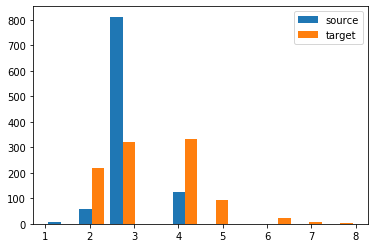

In [56]:
plt.hist([[len(l) for l in source], [len(l) for l in target]],
             label=['source', 'target'])
plt.legend(loc='upper right')
plt.show()

In [ ]:
class Vocab(object):
    def __init__(self, tokens, min_freq=0, use_special_tokens=False):
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[0])
        self.token_freqs.sort(key=lambda x: x[1], reverse=True)
        if use_special_tokens:
            self.pad, self.bos, self.eos, self.unk = (0, 1, 2, 3)
            uniq_tokens = ['<pad>', '<bos>', '<eos>', '<unk>']
        else:
            self.unk, uniq_tokens = 0, ['<unk>']
        uniq_tokens +=  [token for token, freq in self.token_freqs 
                         if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1
            
    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

In [58]:
def build_vocab(tokens):
    tokens = [token for line in tokens for token in line]
    return Vocab(tokens, min_freq=3, use_special_tokens=True)

src_vocab = build_vocab(source)
len(src_vocab)

175

In [59]:
def pad(line, max_len, padding_token):
    if len(line) > max_len:
        return line[:max_len]
    return line + [padding_token] * (max_len - len(line))

pad(src_vocab[source[0]], 10, src_vocab.pad)

[9, 4, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
def build_array(lines, vocab, max_len, is_source, build_mask=False):
    lines = [vocab[line] for line in lines]
    if not is_source:
        lines = [[vocab.bos] + line + [vocab.eos] for line in lines]
    array = torch.LongTensor([pad(line, max_len, vocab.pad) for line in lines])
    valid_len = (array != vocab.pad).sum(axis=1)
    
    if build_mask:
        mask = torch.zeros_like(array).type(torch.float)
        for i in range(len(valid_len)):
            mask[i, :valid_len[i]]=1.
        return array, valid_len, mask

    return array, valid_len

In [ ]:
def load_data_nmt(batch_size, max_len): 
    src_vocab, tgt_vocab = build_vocab(source), build_vocab(target)
    src_array, src_valid_len = build_array(source, src_vocab, max_len, True, False)
    tgt_array, tgt_valid_len, tgt_mask = build_array(target, tgt_vocab, max_len, False, True)
    train_data = torch.utils.data.TensorDataset(
        src_array, src_valid_len, tgt_array, tgt_valid_len, tgt_mask)
    train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
    return src_vocab, tgt_vocab, train_iter

In [62]:
src_vocab, tgt_vocab, train_iter = load_data_nmt(batch_size=2, max_len=8)
for X, X_valid_len, Y, Y_valid_len, y_mask in train_iter:
    print('X =', X.type(torch.int), '\nValid lengths for X =', X_valid_len,
          '\nY =', Y.type(torch.int), '\nValid lengths for Y =', Y_valid_len,
          '\nY mask =', y_mask)
    break

X = tensor([[ 5, 87,  4,  0,  0,  0,  0,  0],
        [ 5, 26, 53,  4,  0,  0,  0,  0]], dtype=torch.int32) 
Valid lengths for X = tensor([3, 4]) 
Y = tensor([[  1,  31,   3,   4,   2,   0,   0,   0],
        [  1,   6,  21, 159,   4,   2,   0,   0]], dtype=torch.int32) 
Valid lengths for Y = tensor([5, 6]) 
Y mask = tensor([[1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.]])


In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers, dropout=dropout)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers

    def forward(self, X, *args):
        X = self.embedding(X) 
        X = X.permute(1, 0, 2)
        state = (torch.zeros((self.num_layers, X.shape[1],self.num_hiddens)), torch.zeros((self.num_layers, X.shape[1],self.num_hiddens)))
        out, state = self.rnn(X, state)
        return out, state

In [64]:
encoder = Encoder(vocab_size=10, embed_size=8,
                         num_hiddens=16, num_layers=2)
X = torch.zeros((4, 7)).type(torch.long)
output, state = encoder(X)
output.shape, len(state), state[0].shape, state[1].shape

(torch.Size([7, 4, 16]), 2, torch.Size([2, 4, 16]), torch.Size([2, 4, 16]))

In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        self.num_hiddens = num_hiddens
        self.embed_size = embed_size
        self.vocab_size = vocab_size

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        X = self.embedding(X).permute(1, 0, 2)
        out, state = self.rnn(X, state)
        out = self.dense(out.view(-1, self.num_hiddens)).view(out.shape[0], out.shape[1], self.vocab_size).permute(1, 0, 2)
        return out, state

In [66]:
decoder = Decoder(vocab_size=10, embed_size=8,
                         num_hiddens=16, num_layers=2)
state = decoder.init_state(encoder(X))
out, state = decoder(X, state)
out.shape, len(state), state[0].shape, state[1].shape

(torch.Size([4, 7, 10]), 2, torch.Size([2, 4, 16]), torch.Size([2, 4, 16]))

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

In [ ]:
def train(model, data_iter, lr, num_epochs, out_vocab_size):
    trainer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss(reduction='none')
    tic = time.time()
    for epoch in range(1, num_epochs+1):
        l_sum, num_tokens_sum = 0.0, 0.0
        for batch in data_iter:
            trainer.zero_grad()
            X, X_vlen, Y, Y_vlen, mask = [x for x in batch]
            Y_input, Y_label, Y_vlen, mask = Y[:,:-1], Y[:,1:], Y_vlen-1, mask[:,1:]
            Y_hat, _ = model(X, Y_input, X_vlen, Y_vlen)
            
            l = (loss(Y_hat.reshape(-1,out_vocab_size), Y_label.reshape(-1)) * mask.reshape(-1)).sum() 
            
            l.backward()
            num_tokens = Y_vlen.sum().item()
            trainer.step()
            l_sum += l.item()
            num_tokens_sum += num_tokens

        print("epoch %d, loss %.3f, time %.1f sec" % (
            epoch, l_sum/num_tokens_sum, time.time()-tic))
        tic = time.time()

In [69]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
batch_size, max_len = 64, 10
lr, num_epochs = 0.01, 300

src_vocab, tgt_vocab, train_iter = load_data_nmt(batch_size, max_len)
encoder = Encoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Decoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = EncoderDecoder(encoder, decoder)
train(model, train_iter, lr, num_epochs, len(tgt_vocab))

epoch 1, loss 3.646, time 0.3 sec
epoch 2, loss 2.716, time 0.3 sec
epoch 3, loss 2.402, time 0.3 sec
epoch 4, loss 2.235, time 0.3 sec
epoch 5, loss 2.126, time 0.3 sec
epoch 6, loss 2.037, time 0.3 sec
epoch 7, loss 1.956, time 0.3 sec
epoch 8, loss 1.880, time 0.3 sec
epoch 9, loss 1.813, time 0.3 sec
epoch 10, loss 1.763, time 0.4 sec
epoch 11, loss 1.709, time 0.3 sec
epoch 12, loss 1.654, time 0.3 sec
epoch 13, loss 1.603, time 0.3 sec
epoch 14, loss 1.557, time 0.3 sec
epoch 15, loss 1.524, time 0.3 sec
epoch 16, loss 1.481, time 0.3 sec
epoch 17, loss 1.438, time 0.3 sec
epoch 18, loss 1.410, time 0.3 sec
epoch 19, loss 1.373, time 0.3 sec
epoch 20, loss 1.335, time 0.4 sec
epoch 21, loss 1.299, time 0.3 sec
epoch 22, loss 1.263, time 0.3 sec
epoch 23, loss 1.232, time 0.3 sec
epoch 24, loss 1.196, time 0.3 sec
epoch 25, loss 1.168, time 0.3 sec
epoch 26, loss 1.140, time 0.3 sec
epoch 27, loss 1.108, time 0.3 sec
epoch 28, loss 1.080, time 0.3 sec
epoch 29, loss 1.055, time 0.

In [ ]:
def translate(model, src_sentence, src_vocab, tgt_vocab, max_len):
    src_tokens = src_vocab[src_sentence.lower().split(' ')]
    src_len = len(src_tokens)
    if src_len < max_len:
        src_tokens += [src_vocab.pad] * (max_len - src_len)
    enc_X = torch.LongTensor(src_tokens)
    enc_valid_length = torch.LongTensor([src_len])
    enc_outputs = model.encoder(enc_X.unsqueeze(axis=0), enc_valid_length)
    dec_state = model.decoder.init_state(enc_outputs, enc_valid_length)
    dec_X = torch.LongTensor([tgt_vocab.bos]).unsqueeze(axis=0)
    predict_tokens = []
    for _ in range(max_len):
        Y, dec_state = model.decoder(dec_X, dec_state)
        dec_X = Y.argmax(axis=2)
        py = dec_X.squeeze(axis=0).type(torch.long).item()
        if py == tgt_vocab.eos:
            break
        predict_tokens.append(py)
    return ' '.join(tgt_vocab.to_tokens(predict_tokens))

In [71]:
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !']:
    print(sentence + ' => ' + translate(
        model, sentence, src_vocab, tgt_vocab, max_len))

Go . => va !
Wow ! => <unk> !
I'm OK . => je vais bien .
I won ! => j'ai gagné !


In [72]:
'''-> INPUT: GO . <pad> <pad> <pad>
    
    
-> TARGET:     <bos>  va    !  <eos> <pad> <pad>
-> MASK:         1    1     1    1     0     0
-> PREDICTION: <bos> HAHA HAHA <eos> <pad> <pad>
-> LOSS:         2    1.3   0.4  1     34    19
    
'''


'-> INPUT: GO . <pad> <pad> <pad>\n    \n    \n-> TARGET:     <bos>  va    !  <eos> <pad> <pad>\n-> MASK:         1    1     1    1     0     0\n-> PREDICTION: <bos> HAHA HAHA <eos> <pad> <pad>\n-> LOSS:         2    1.3   0.4  1     34    19\n    \n'

## Внимание

## Dot Product Attention

$$\alpha(\mathbf Q, \mathbf K) = \langle \mathbf Q, \mathbf K^T \rangle /\sqrt{d}.$$

In [ ]:
class DotProductAttention(nn.Module):  
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # query: (batch_size, #queries, d)
    # key: (batch_size, #kv_pairs, d)
    # value: (batch_size, #kv_pairs, dim_v)
    def forward(self, query, key, value):
        d = query.shape[-1]
        scores = torch.bmm(query, key.permute(0, 2, 1)) / math.sqrt(d)
        attention_weights = self.dropout(torch.softmax(scores, dim=-1))
        return torch.bmm(attention_weights, value)

In [74]:
atten = DotProductAttention(dropout=0.5)
keys = torch.ones((2,10,2))
values = torch.arange(40).reshape((1,10,4)).repeat(2,1,1).type(torch.float)
atten(torch.ones((2,1,2)), keys, values)

tensor([[[20.8000, 21.6000, 22.4000, 23.2000]],

        [[ 0.0000,  0.2000,  0.4000,  0.6000]]])

## Multilayer Perception Attention

$\mathbf W_k\in\mathbb R^{h\times d_k}$, $\mathbf W_q\in\mathbb R^{h\times d_q}$, and $\mathbf v\in\mathbb R^{p}$:

$$\alpha(\mathbf k, \mathbf q) = \mathbf v^T \text{tanh}(\mathbf W_k \mathbf k + \mathbf W_q\mathbf q). $$



In [ ]:
class MLPAttention(nn.Module):  
    def __init__(self, inputs, units, dropout, **kwargs):
        super(MLPAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(inputs, units, bias=False)
        self.W_q = nn.Linear(inputs, units, bias=False)
        self.v = nn.Linear(units, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value):
        query, key = torch.tanh(self.W_k(query)), torch.tanh(self.W_q(key))
        # expand query to (batch_size, #querys, 1, units), and key to 
        # (batch_size, 1, #kv_pairs, units). Then plus them with broadcast.  
        features = query.unsqueeze(2) + key.unsqueeze(1)
        scores = self.v(features).squeeze(dim=-1)
        attention_weights = self.dropout(scores.softmax(dim=-1))
        return torch.bmm(attention_weights, value)

In [76]:
atten = MLPAttention(2, units=8, dropout=0.1)
atten(torch.ones((2,1,2)), keys, values)

tensor([[[20.0000, 21.1111, 22.2222, 23.3333]],

        [[19.1111, 20.1111, 21.1111, 22.1111]]], grad_fn=<BmmBackward>)

In [ ]:
class AttentionDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.attention_cell = MLPAttention(num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        self.num_hiddens = num_hiddens
        self.embed_size = embed_size
        self.vocab_size = vocab_size

    def init_state(self, enc_outputs, *args):
        return (enc_outputs[0].permute(1,0,2), enc_outputs[1])

    def forward(self, X, state):
        enc_outputs, hidden_state = state
        X = self.embedding(X).permute(1, 0, 2)
        outputs = []
        for x in X:
            # query shape: (batch_size, 1, hidden_size)
            query = hidden_state[0][-1].unsqueeze(1)
            # context has same shape as query
            context = self.attention_cell(query, enc_outputs, enc_outputs)
            # concatenate on the feature dimension
            x = torch.cat([context, x.unsqueeze(1)], dim=-1)
            # reshape x to (1, batch_size, embed_size+hidden_size)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state]
            
            
       # out, state = self.rnn(X, state)
       # out = self.dense(out.view(-1, self.num_hiddens)).view(out.shape[0], out.shape[1], self.vocab_size).permute(1, 0, 2)
       # return out, state

In [78]:
encoder = Encoder(vocab_size=10, embed_size=8,
                             num_hiddens=16, num_layers=2)
decoder = AttentionDecoder(vocab_size=10, embed_size=8, 
                                  num_hiddens=16, num_layers=2)
X = torch.zeros((4, 7), dtype=torch.long)
state = decoder.init_state(encoder(X))
out, state = decoder(X, state)
out.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 2, torch.Size([4, 7, 16]), 2, torch.Size([2, 4, 16]))

In [79]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
batch_size, max_len = 64, 10
lr, num_epochs = 0.01, 300

src_vocab, tgt_vocab, train_iter = load_data_nmt(batch_size, max_len)
encoder = Encoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = AttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = EncoderDecoder(encoder, decoder)
train(model, train_iter, lr, num_epochs, len(tgt_vocab))

epoch 1, loss 3.610, time 0.5 sec
epoch 2, loss 2.757, time 0.6 sec
epoch 3, loss 2.543, time 0.4 sec
epoch 4, loss 2.373, time 0.5 sec
epoch 5, loss 2.199, time 0.5 sec
epoch 6, loss 2.046, time 0.4 sec
epoch 7, loss 1.950, time 0.4 sec
epoch 8, loss 1.882, time 0.5 sec
epoch 9, loss 1.811, time 0.5 sec
epoch 10, loss 1.756, time 0.5 sec
epoch 11, loss 1.703, time 0.4 sec
epoch 12, loss 1.656, time 0.5 sec
epoch 13, loss 1.618, time 0.5 sec
epoch 14, loss 1.575, time 0.4 sec
epoch 15, loss 1.537, time 0.5 sec
epoch 16, loss 1.494, time 0.5 sec
epoch 17, loss 1.439, time 0.5 sec
epoch 18, loss 1.402, time 0.5 sec
epoch 19, loss 1.364, time 0.7 sec
epoch 20, loss 1.330, time 0.6 sec
epoch 21, loss 1.293, time 0.5 sec
epoch 22, loss 1.255, time 0.5 sec
epoch 23, loss 1.209, time 0.5 sec
epoch 24, loss 1.180, time 0.6 sec
epoch 25, loss 1.143, time 0.7 sec
epoch 26, loss 1.106, time 0.6 sec
epoch 27, loss 1.074, time 0.5 sec
epoch 28, loss 1.053, time 0.5 sec
epoch 29, loss 1.025, time 0.

In [80]:
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !']:
    print(sentence + ' => ' + translate(
        model, sentence, src_vocab, tgt_vocab, max_len))

Go . => va !
Wow ! => <unk> !
I'm OK . => je vais bien .
I won ! => je l'ai emporté !


# Hometask

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "" # username from the json file
os.environ['KAGGLE_KEY'] = "" # key from the json file

In [82]:
!git clone https://github.com/Phylliida/Dialogue-Datasets.git

fatal: destination path 'Dialogue-Datasets' already exists and is not an empty directory.


In [86]:
with open('/content/Dialogue-Datasets/TwitterConvCorpus.txt') as f:
    raw_text = f.read()
print(raw_text[0:1000])

what's up dadyo when did you get back on Twitter? Haha
like 2 weeks ago and it's going as terribly as I remember, but Deg is still hilarious so it's ok
literally never about that account, love it.



Answer me this fellow Apple peoples: how many times in the past year have you used the escape key?
about 50 times today. Terminal vim user.
Seems the major complaints so far are from VIM users like yourself. I’m wondering how force quit is gonna work.
cmd+opt+esc is good but still available via menubar



There was a greasy kid at highline who was basically miles dipped in a bucket of ranch
I'm disgusted
he flashed us then we scored so he sadly put his shirt back on 😂#fuckhighline
what a piece of shit



I killed a mouse today!  😼
Yay, you great hunter. I’ve killed lots of lizards and bugs but never a mouse.
I don't know what the mouse was thinking??  Why come into a house with 2 ferocious felines??
and then that mouse had the nerve to try to eat our kibble!  Let this be a lesson fur all t

In [95]:
num_examples = 5000
source, target = [], []
for i, line in enumerate(raw_text.split('\n\n\n')):
    if i > num_examples:
        break
    if len(line.strip().split('\n')) <= 1:
      continue
    #print(line, line.strip().split('\n'))
    source.append(line.strip().split('\n')[0].split(' '))
    target.append(line.strip().split('\n')[1].split(' '))

source[0:3], target[0:3], len(source), len(target)

([["what's",
   'up',
   'dadyo',
   'when',
   'did',
   'you',
   'get',
   'back',
   'on',
   'Twitter?',
   'Haha'],
  ['Answer',
   'me',
   'this',
   'fellow',
   'Apple',
   'peoples:',
   'how',
   'many',
   'times',
   'in',
   'the',
   'past',
   'year',
   'have',
   'you',
   'used',
   'the',
   'escape',
   'key?'],
  ['There',
   'was',
   'a',
   'greasy',
   'kid',
   'at',
   'highline',
   'who',
   'was',
   'basically',
   'miles',
   'dipped',
   'in',
   'a',
   'bucket',
   'of',
   'ranch']],
 [['like',
   '2',
   'weeks',
   'ago',
   'and',
   "it's",
   'going',
   'as',
   'terribly',
   'as',
   'I',
   'remember,',
   'but',
   'Deg',
   'is',
   'still',
   'hilarious',
   'so',
   "it's",
   'ok'],
  ['about', '50', 'times', 'today.', 'Terminal', 'vim', 'user.'],
  ["I'm", 'disgusted']],
 1900,
 1900)

In [96]:
src_vocab, tgt_vocab, train_iter = load_data_nmt(batch_size=2, max_len=200)
for X, X_valid_len, Y, Y_valid_len, y_mask in train_iter:
    print('X =', X.type(torch.int), '\nValid lengths for X =', X_valid_len,
          '\nY =', Y.type(torch.int), '\nValid lengths for Y =', Y_valid_len,
          '\nY mask =', y_mask)
    break

X = tensor([[  4,  43,  64,  76,   3,  18, 326,   8,   3,  30,   3,  19, 878,   3,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,

In [97]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, max_len = 64, 20
lr, num_epochs = 0.01, 300

src_vocab, tgt_vocab, train_iter = load_data_nmt(batch_size, max_len)
encoder = Encoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = AttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = EncoderDecoder(encoder, decoder)
train(model, train_iter, lr, num_epochs, len(tgt_vocab))

epoch 1, loss 5.223, time 2.7 sec
epoch 2, loss 4.727, time 2.4 sec
epoch 3, loss 4.699, time 2.5 sec
epoch 4, loss 4.669, time 2.3 sec
epoch 5, loss 4.653, time 2.4 sec
epoch 6, loss 4.635, time 2.4 sec
epoch 7, loss 4.614, time 2.4 sec
epoch 8, loss 4.594, time 2.5 sec
epoch 9, loss 4.576, time 2.3 sec
epoch 10, loss 4.544, time 2.3 sec
epoch 11, loss 4.498, time 2.3 sec
epoch 12, loss 4.445, time 2.4 sec
epoch 13, loss 4.399, time 2.6 sec
epoch 14, loss 4.357, time 2.7 sec
epoch 15, loss 4.322, time 2.4 sec
epoch 16, loss 4.279, time 2.4 sec
epoch 17, loss 4.244, time 2.4 sec
epoch 18, loss 4.208, time 2.3 sec
epoch 19, loss 4.176, time 2.3 sec
epoch 20, loss 4.137, time 2.5 sec
epoch 21, loss 4.099, time 2.5 sec
epoch 22, loss 4.060, time 2.5 sec
epoch 23, loss 4.018, time 2.3 sec
epoch 24, loss 3.979, time 2.3 sec
epoch 25, loss 3.936, time 2.7 sec
epoch 26, loss 3.901, time 2.6 sec
epoch 27, loss 3.858, time 2.3 sec
epoch 28, loss 3.817, time 2.4 sec
epoch 29, loss 3.770, time 2.

In [100]:
'''what's up dadyo when did you get back on Twitter? Haha
like 2 weeks ago and it's going as terribly as I remember, but Deg is still hilarious so it's ok

Answer me this fellow Apple peoples: how many times in the past year have you used the escape key?
about 50 times today. Terminal vim user.

There was a greasy kid at highline who was basically miles dipped in a bucket of ranch
I'm disgusted

I killed a mouse today!  😼
Yay, you great hunter. I’ve killed lots of lizards and bugs but never a mouse.'''

for sentence in ['Hey you! What''s your name?', 'Whats UP?', "How are you?", 'Hello!', 'what''s up dadyo when did you get back on Twitter? Haha', 'I killed a mouse today!']:
    print(sentence + ' => ' + translate(
        model, sentence, src_vocab, tgt_vocab, max_len))

Hey you! Whats your name? => <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Whats UP? => <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
How are you? => <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Hello! => <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
whats up dadyo when did you get back on Twitter? Haha => <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
I killed a mouse today! => <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


In [102]:
embed_size, num_hiddens, num_layers, dropout = 64, 64, 3, 0.0
batch_size, max_len = 64, 20
lr, num_epochs = 0.05, 50

src_vocab, tgt_vocab, train_iter = load_data_nmt(batch_size, max_len)
encoder = Encoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = AttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = EncoderDecoder(encoder, decoder)
train(model, train_iter, lr, num_epochs, len(tgt_vocab))

epoch 1, loss 5.239, time 4.8 sec
epoch 2, loss 4.918, time 6.4 sec
epoch 3, loss 4.877, time 6.2 sec
epoch 4, loss 4.843, time 6.1 sec
epoch 5, loss 4.844, time 6.2 sec
epoch 6, loss 4.810, time 5.9 sec
epoch 7, loss 4.820, time 6.3 sec
epoch 8, loss 4.819, time 6.3 sec
epoch 9, loss 4.804, time 5.9 sec
epoch 10, loss 4.800, time 6.0 sec
epoch 11, loss 4.801, time 5.8 sec
epoch 12, loss 4.801, time 6.1 sec
epoch 13, loss 4.815, time 6.1 sec
epoch 14, loss 4.805, time 5.9 sec
epoch 15, loss 4.809, time 5.8 sec
epoch 16, loss 4.788, time 5.5 sec
epoch 17, loss 4.794, time 5.4 sec
epoch 18, loss 4.758, time 6.2 sec
epoch 19, loss 4.706, time 6.6 sec
epoch 20, loss 4.697, time 6.8 sec
epoch 21, loss 4.691, time 6.7 sec
epoch 22, loss 4.667, time 7.2 sec
epoch 23, loss 4.660, time 7.0 sec
epoch 24, loss 4.651, time 7.2 sec
epoch 25, loss 4.650, time 7.7 sec
epoch 26, loss 4.624, time 8.2 sec
epoch 27, loss 4.627, time 9.0 sec
epoch 28, loss 4.606, time 8.6 sec
epoch 29, loss 4.585, time 8.

In [ ]:
def train(model, data_iter, lr, num_epochs, out_vocab_size, trainer=torch.optim.Adam(model.parameters(), lr=lr)):
    loss = nn.CrossEntropyLoss(reduction='none')
    tic = time.time()
    for epoch in range(1, num_epochs+1):
        l_sum, num_tokens_sum = 0.0, 0.0
        for batch in data_iter:
            trainer.zero_grad()
            X, X_vlen, Y, Y_vlen, mask = [x for x in batch]
            Y_input, Y_label, Y_vlen, mask = Y[:,:-1], Y[:,1:], Y_vlen-1, mask[:,1:]
            Y_hat, _ = model(X, Y_input, X_vlen, Y_vlen)
            
            l = (loss(Y_hat.reshape(-1,out_vocab_size), Y_label.reshape(-1)) * mask.reshape(-1)).sum() 
            
            l.backward()
            num_tokens = Y_vlen.sum().item()
            trainer.step()
            l_sum += l.item()
            num_tokens_sum += num_tokens

        print("epoch %d, loss %.3f, time %.1f sec" % (
            epoch, l_sum/num_tokens_sum, time.time()-tic))
        tic = time.time()

In [104]:
embed_size, num_hiddens, num_layers, dropout = 64, 64, 2, 0.0
batch_size, max_len = 64, 20
lr, num_epochs = 0.01, 50

src_vocab, tgt_vocab, train_iter = load_data_nmt(batch_size, max_len)
encoder = Encoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = AttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = EncoderDecoder(encoder, decoder)
train(model, train_iter, lr, num_epochs, len(tgt_vocab), trainer=torch.optim.SGD(model.parameters(), lr=lr))

epoch 1, loss 5.750, time 3.8 sec
epoch 2, loss 4.832, time 3.7 sec
epoch 3, loss 4.731, time 3.8 sec
epoch 4, loss 4.677, time 3.7 sec
epoch 5, loss 4.609, time 4.1 sec
epoch 6, loss 4.598, time 4.0 sec
epoch 7, loss 4.530, time 4.1 sec
epoch 8, loss 4.491, time 3.7 sec
epoch 9, loss 4.444, time 3.7 sec
epoch 10, loss 4.395, time 3.8 sec
epoch 11, loss 4.320, time 3.7 sec
epoch 12, loss 4.288, time 3.7 sec
epoch 13, loss 4.238, time 3.9 sec
epoch 14, loss 4.166, time 3.9 sec
epoch 15, loss 4.119, time 3.7 sec
epoch 16, loss 4.070, time 3.8 sec
epoch 17, loss 3.972, time 3.6 sec
epoch 18, loss 3.920, time 3.6 sec
epoch 19, loss 3.859, time 3.7 sec
epoch 20, loss 3.753, time 3.7 sec
epoch 21, loss 3.676, time 4.0 sec
epoch 22, loss 3.623, time 3.7 sec
epoch 23, loss 3.529, time 3.9 sec
epoch 24, loss 3.439, time 3.7 sec
epoch 25, loss 3.375, time 3.7 sec
epoch 26, loss 3.277, time 3.7 sec
epoch 27, loss 3.208, time 3.7 sec
epoch 28, loss 3.118, time 3.6 sec
epoch 29, loss 3.033, time 3.

In [105]:
for sentence in ['Hey you! What''s your name?', 'Whats UP?', "How are you?", 'Hello!', 'what''s up dadyo when did you get back on Twitter? Haha', 'I killed a mouse today!']:
    print(sentence + ' => ' + translate(
        model, sentence, src_vocab, tgt_vocab, max_len))

Hey you! Whats your name? => <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Whats UP? => <unk> <unk>
How are you? => <unk> <unk>
Hello! => <unk> <unk>
whats up dadyo when did you get back on Twitter? Haha => <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
I killed a mouse today! => <unk> <unk>


In [106]:
lr = 0.001
train(model, train_iter, lr, num_epochs, len(tgt_vocab), trainer=torch.optim.SGD(model.parameters(), lr=lr))

epoch 1, loss 1.595, time 3.6 sec
epoch 2, loss 1.518, time 3.6 sec
epoch 3, loss 1.484, time 3.8 sec
epoch 4, loss 1.459, time 4.0 sec
epoch 5, loss 1.439, time 3.8 sec
epoch 6, loss 1.422, time 4.0 sec
epoch 7, loss 1.407, time 3.6 sec
epoch 8, loss 1.394, time 3.7 sec
epoch 9, loss 1.381, time 3.5 sec
epoch 10, loss 1.369, time 3.7 sec
epoch 11, loss 1.358, time 3.8 sec
epoch 12, loss 1.347, time 3.9 sec
epoch 13, loss 1.336, time 3.7 sec
epoch 14, loss 1.326, time 3.6 sec
epoch 15, loss 1.316, time 3.6 sec
epoch 16, loss 1.307, time 3.7 sec
epoch 17, loss 1.298, time 3.5 sec
epoch 18, loss 1.289, time 3.6 sec
epoch 19, loss 1.280, time 3.5 sec
epoch 20, loss 1.271, time 3.8 sec
epoch 21, loss 1.263, time 3.6 sec
epoch 22, loss 1.254, time 3.8 sec
epoch 23, loss 1.246, time 3.5 sec
epoch 24, loss 1.237, time 3.6 sec
epoch 25, loss 1.229, time 3.6 sec
epoch 26, loss 1.222, time 3.6 sec
epoch 27, loss 1.214, time 3.6 sec
epoch 28, loss 1.205, time 3.7 sec
epoch 29, loss 1.198, time 3.

In [107]:
for sentence in ['Hey you! What''s your name?', 'Whats UP?', "How are you?", 'Hello!', 'what''s up dadyo when did you get back on Twitter? Haha', 'I killed a mouse today!']:
    print(sentence + ' => ' + translate(
        model, sentence, src_vocab, tgt_vocab, max_len))

Hey you! Whats your name? => <unk> <unk> <unk> <unk>
Whats UP? => <unk> <unk>
How are you? => <unk>
Hello! => <unk> <unk>
whats up dadyo when did you get back on Twitter? Haha => <unk> <unk>
I killed a mouse today! => <unk>


In [108]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
batch_size, max_len = 64, 20
lr, num_epochs = 0.01, 5

src_vocab, tgt_vocab, train_iter = load_data_nmt(batch_size, max_len)
encoder = Encoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = AttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = EncoderDecoder(encoder, decoder)
train(model, train_iter, lr, num_epochs, len(tgt_vocab), trainer=torch.optim.SGD(model.parameters(), lr=lr))

epoch 1, loss 5.258, time 2.1 sec
epoch 2, loss 4.846, time 2.2 sec
epoch 3, loss 4.740, time 2.3 sec
epoch 4, loss 4.659, time 2.5 sec
epoch 5, loss 4.620, time 2.2 sec


In [109]:
for sentence in ['Hey you! What''s your name?', 'Whats UP?', "How are you?", 'Hello!', 'what''s up dadyo when did you get back on Twitter? Haha', 'I killed a mouse today!']:
    print(sentence + ' => ' + translate(
        model, sentence, src_vocab, tgt_vocab, max_len))

Hey you! Whats your name? => <unk>
Whats UP? => <unk>
How are you? => <unk>
Hello! => <unk>
whats up dadyo when did you get back on Twitter? Haha => <unk>
I killed a mouse today! => <unk>


In [110]:
lr = 0.001
train(model, train_iter, lr, num_epochs, len(tgt_vocab), trainer=torch.optim.SGD(model.parameters(), lr=lr))

epoch 1, loss 4.521, time 2.3 sec
epoch 2, loss 4.513, time 2.2 sec
epoch 3, loss 4.506, time 2.4 sec
epoch 4, loss 4.499, time 2.1 sec
epoch 5, loss 4.492, time 2.1 sec


In [111]:
for sentence in ['Hey you! What''s your name?', 'Whats UP?', "How are you?", 'Hello!', 'what''s up dadyo when did you get back on Twitter? Haha', 'I killed a mouse today!']:
    print(sentence + ' => ' + translate(
        model, sentence, src_vocab, tgt_vocab, max_len))

Hey you! Whats your name? => <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Whats UP? => <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
How are you? => <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Hello! => <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
whats up dadyo when did you get back on Twitter? Haha => <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
I killed a mouse today! => <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
